Ref: https://www.kaggle.com/ipythonx/tf-3d-2d-model-for-brain-tumor-classification

**Version 8 Update**

- Update `tf.data` pipeline in a clean modular way, would be easy to tweak
- Add random data augmentation on each input slice using `tf.image.random_*` module 
- Add random `cutout` augmentation. 
- Add `3D` pre-trained modeling setup: `efficientnet-3d` and others. 
- Add `2D` modeling setup either: `efficientnet-2d` and others.
- Basic training of `3D` and `2D` modeling with shape of (`312, 312, 4, 1`) and (`312, 312, 4`) respectively. 


**Note**: The pre-trained weights of `3D` model is taken from [ZFTurbo/efficientnet_3D](https://github.com/ZFTurbo/efficientnet_3D) and [ZFTurbo/classification_models_3D](https://github.com/ZFTurbo/classification_models_3D). The weight files are uploaded and can be found from here ([efnet-3d](https://www.kaggle.com/ipythonx/keras-3d-efficientnet-imagenet-weights-b0b7)) and here ([classification-3d](https://www.kaggle.com/ipythonx/pretrained-3d-model-weights-keras)) respectively. 


**Version 3 Update**

- Wrap up `keras` sequence generator to `tf.data` API 
- Add data augmentation by using `keras` preprocessing layers 
- Subclass the model for tweaking gradient before update and reg loss 
- Train the model (`InceptionResNet3D`) with shape of (`256, 256, 20, 1`)


**Note**: As there are many empty image (`img.mean() == 0`) among four modalities, we found that, the training progress is bit unstable. We need to find out a better and efficient technique for `n` depth 3D model training. Also, we've seen that, among four series or modalities, training with only `T2w` was compratively better. 

---

## RSNA-MICCAI Brain Tumor Radiogenomic Classification

In this baseline example, we will be building a 3D convolutional neural network to predict the status of a genetic biomaker important for brain cancer treatment in the **mpMRI** scans that includes the following four types of images for single study or patient. 

```
- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)
```

In the training data, each study (or each patient id e.g `00000`) belongs to a single label (`train_labels.csv`). Each of this study has further 4 series (`FLAIR`, `T1w`, `T1Gd`, `T2`), and each series has multiple images, in a DICOM format. The file structure is something looks like as follows:

```
Training/Validation/Testing
│
└─── 00000
│   │
│   └─── FLAIR
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T1w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T1wCE
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T2w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ .....
└─── 00001
│   │ ...
└─── 00002
│   │ ...
```

## Simple EDA

In [41]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os, glob, random, cv2, glob, pydicom
from sklearn.model_selection import StratifiedKFold
import time

import tensorflow as tf
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Conv3D, GlobalAveragePooling3D, DepthwiseConv3D
from tensorflow.keras.applications import *
import tensorflow_addons as tfa
from tensorflow.keras.layers.experimental.preprocessing import (RandomFlip,
                                                                RandomRotation, 
                                                                RandomTranslation)
from tensorflow import keras 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow.keras.utils import plot_model

import efficientnet_3D.tfkeras as efn # include_top = false 
from classification_models_3D.tfkeras import Classifiers # include_top = true

from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import DepthwiseConv3D

ImportError: cannot import name 'DepthwiseConv3D' from 'tensorflow.keras.layers' (C:\Users\Jia Jun\anaconda3\lib\site-packages\tensorflow\keras\layers\__init__.py)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
df = pd.read_csv('D:/rsna/train_labels.csv'); print(df.shape)
df.head()

(585, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [4]:
df.MGMT_value.value_counts()

1    307
0    278
Name: MGMT_value, dtype: int64

In [5]:
train_sample_path = 'D:/rsna/train'
len(os.listdir(train_sample_path)), df.BraTS21ID.nunique()

(585, 585)

**Visualization**

In [6]:
def read_dicom_xray(path):
    data = pydicom.read_file(path).pixel_array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

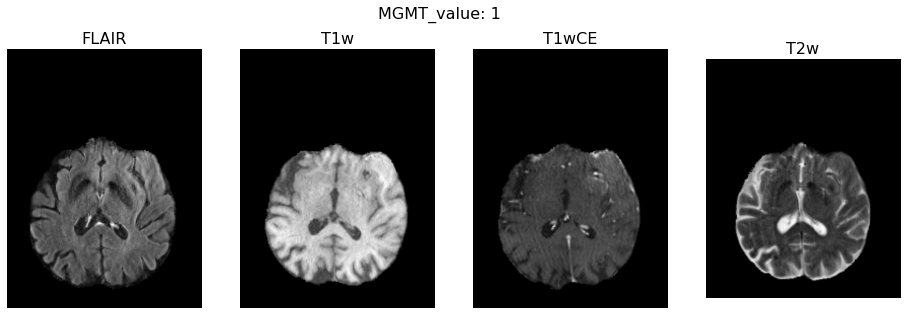

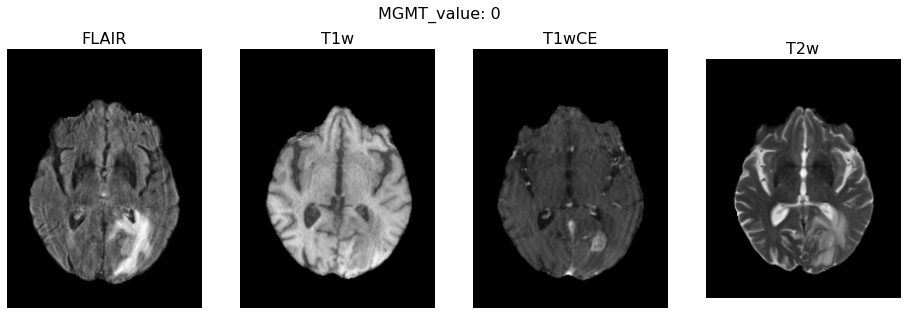

In [7]:
# following function took from: https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling?scriptVersionId=68202876&cellId=11
def visualize_sample(
    brats21id, 
    mgmt_value,
    slice_i,
    types=("FLAIR", "T1w", "T1wCE", "T2w")
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        train_sample_path, 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = read_dicom_xray(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()
    
    
for i in random.sample(range(df.shape[0]), 2):
    visualize_sample(df.iloc[i]["BraTS21ID"], df.iloc[i]["MGMT_value"], slice_i=0.5)

# Data Loader

**Note**: For each study, we will pick **5** middle dicom or image samples at cetain interval from each of the four series (`FLAIR`, `T1w`, `T1Gd`, `T2`) for our 3D model input, e.g `input_shape: (None, height, weights, 5*4, 1)`. So, for picking 5 samples from each series, the depth would be `4 * 5` or `20` for each patient id or study id. However, we probabely need to find some better technique to pick samples from each of these four series though. For now, we're doing kinda random stuff. For example: check the following illustration; for the 3D model the input size would be : `height, width, 12, 1`. Also, as we already notice, there're too much black pixel, we will try to address that too. 


![quick png](https://user-images.githubusercontent.com/17668390/126070190-4a2d8aed-9dd8-4bee-aa15-f95429553a9c.png)




**Keras Sequence to TensorFlow tf.Data API**

It's known that, `tf.data` is more efficient when it comes to data pipelines compare to others, e.g. `keras` sequences data generator. Here we will try to wrap up an **existing `keras` sequence generator** to `tf.data` API using [tf.data.Dataset.from_generator function](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). 

In [8]:
'''
Will need to do filtering before setting up the dataframe as below due to different planes.
Read in from feather dataset.
'''

'\nWill need to do filtering before setting up the dataframe as below due to different planes.\nRead in from feather dataset.\n'

In [9]:
df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


## Extracting Plane

Ref: https://www.kaggle.com/davidbroberts/determining-mr-image-planes

Within each 4 Modalities there exists different planes as well. Most pre-trained networks works with the Axial plane and does not provide for Coronal & Saggital plane. Hence, we will first look at images which are Axial plane only first.

The following cell does the following:
<br>1.Load four images from a study
<br>2.Grab the 'middle' image of each sequence
<br>3.Get the plane of each image/sequence

In [ ]:
# Run only once

# specify the dataset and the series names
series_names = ['FLAIR','T1w','T1wCE','T2w']
directory = 'D:/rsna'

# Get a list of images in a series
def get_series_list(dataset, study_id, series_name):

    series_list = []

    for subdirs, dirs, files in os.walk(directory + '/' + dataset + '/' + study_id + "/" + series_name):
        series_list = os.listdir(directory + '/' + dataset + '/' + study_id + '/' + series_name)
        
    return series_list


# Find the image in the middle of each series stack, returns a list of four images
def get_middle_images(study_id, dataset):
    
    middle_images = []
    
    # Iterate through each of the four series directories and get the files 
    for ser in series_names:
        series_files = get_series_list(dataset, study_id, ser)
        series_df = pd.DataFrame(columns = ['image','instance_number'])

        # Get the DICOM InstanceNumber tag to order the images since we can't rely on the filenames to be in order
        for s in series_files:
            img = pydicom.dcmread(directory + "/" + dataset + "/" + study_id + "/" + ser + "/" + s)
            series_df.loc[len(series_df.index)] = [s, img[0x0020,0x0013].value]
 
        series_df['instance_number'] = pd.to_numeric(series_df['instance_number'])

        # Sort the image list by InstanceNumber
        series_df = series_df.sort_values(by=['instance_number'])
        
        # Find the image in the middle of the list
        middle_index = int(series_df.shape[0] / 2)
        middle_image = series_df.iloc[middle_index]['image']

        middle_images.append(ser + "/" + middle_image)

    return middle_images

# Convert the Image Orientation Patient tag cosine values into a text string of the plane.
# This represents the plane the image is 'closest to' .. it does not explain any obliqueness
def get_image_plane(loc):

    row_x = round(loc[0])
    row_y = round(loc[1])
    row_z = round(loc[2])
    col_x = round(loc[3])
    col_y = round(loc[4])
    col_z = round(loc[5])

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 0:
        return "Coronal"

    if row_x == 0 and row_y == 1 and col_x == 0 and col_y == 0:
        return "Sagittal"

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 1:
        return "Axial"

    return "Unknown"

# Extract for Train
# ID / Directory name of the study we want to get
study_ids = (path/'train').ls().attrgot('name')
FLAIR = []
T1w = []
T1wCE = []
T2w = []

dataset = 'train'

for study_id in tqdm(study_ids):
    middle_images = get_middle_images(study_id, dataset)
    for img in middle_images:
        image = pydicom.dcmread(directory + "/" + dataset + "/" + study_id + "/" + img)
        ser = img.split("/")
        image_orientation_patient = image[0x0020,0x0037]
        plane = get_image_plane(image_orientation_patient)
        
        if ser[0] == 'FLAIR':
            FLAIR.append(plane)
        elif ser[0] == 'T1w':
            T1w.append(plane)
        elif ser[0] == 'T1wCE':
            T1wCE.append(plane)
        elif ser[0] == 'T2w':
            T2w.append(plane)
        else:
            print('error')
            
            
FLAIR_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': FLAIR, 'SeriesDescription': ['FLAIR']*len(FLAIR)})
T1w_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': T1w, 'SeriesDescription': ['T1w']*len(T1w)})
T1wCE_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': T1wCE, 'SeriesDescription': ['T1wCE']*len(T1wCE)})
T2w_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': T2w, 'SeriesDescription': ['T2w']*len(T2w)})
agg_plane = FLAIR_plane.append(T1w_plane).append(T1wCE_plane).append(T2w_plane).reset_index(drop=True)
agg_plane.to_feather('trn_plane.fth')



# Extract for Test
# ID / Directory name of the study we want to get
study_ids = (path/'test').ls().attrgot('name')
FLAIR = []
T1w = []
T1wCE = []
T2w = []

dataset = 'test'

for study_id in tqdm(study_ids):
    middle_images = get_middle_images(study_id, dataset)
    for img in middle_images:
        image = pydicom.dcmread(directory + "/" + dataset + "/" + study_id + "/" + img)
        ser = img.split("/")
        image_orientation_patient = image[0x0020,0x0037]
        plane = get_image_plane(image_orientation_patient)
        
        if ser[0] == 'FLAIR':
            FLAIR.append(plane)
        elif ser[0] == 'T1w':
            T1w.append(plane)
        elif ser[0] == 'T1wCE':
            T1wCE.append(plane)
        elif ser[0] == 'T2w':
            T2w.append(plane)
        else:
            print('error')
            
FLAIR_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': FLAIR, 'SeriesDescription': ['FLAIR']*len(FLAIR)})
T1w_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': T1w, 'SeriesDescription': ['T1w']*len(T1w)})
T1wCE_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': T1wCE, 'SeriesDescription': ['T1wCE']*len(T1wCE)})
T2w_plane = pd.DataFrame({'BraTS21ID': study_ids, 'Plane': T2w, 'SeriesDescription': ['T2w']*len(T2w)})
agg_plane = FLAIR_plane.append(T1w_plane).append(T1wCE_plane).append(T2w_plane).reset_index(drop=True)
agg_plane.to_feather('tst_plane.fth')

After extraction, take a look at the saved extracted Feather file

### Looking at the Planes of Train & Test set

In [10]:
trn_plane = pd.read_feather('trn_plane.fth')
trn_plane.head(2)

,BraTS21ID,Plane,SeriesDescription
0,00000,Coronal,FLAIR
1,00002,Sagittal,FLAIR


In [11]:
print('Total Patients in datasets: ', trn_plane['BraTS21ID'].nunique())
print('Total Patients in datasets with Axial plane: ', trn_plane.loc[trn_plane['Plane'] == 'Axial', 'BraTS21ID'].nunique())

Total Patients in datasets:  585
Total Patients in datasets with Axial plane:  582


As can be seen, some patients doesn't have Axial plane scans. This may be problematic as this means that the model will need to account for the other 2 types of planes as well. As of now, lets look at the Axial plane only.

In [12]:
tst_plane = pd.read_feather('tst_plane.fth')
print('Total Patients in datasets: ', tst_plane['BraTS21ID'].nunique())
print('Total Patients in datasets with Axial plane: ', tst_plane.loc[tst_plane['Plane'] == 'Axial', 'BraTS21ID'].nunique())

Total Patients in datasets:  87
Total Patients in datasets with Axial plane:  87


Luckily for the test set there is no such issue, but if the model is evaluated at a hidden test set, then there may still be an issue.

The strategy will be as follows: The model is only trained on images that are Axial in plane. Since there are 4 modalities, then the number of slices to be taken from the image will be in multiples of 12.
<br><ins>Such that, where n is an integer:</ins>
<br>Only 1 modality: 12n slices from each modality
<br>2 modalities: 6n slices ea.
<br>3 modalities: 4n ea
<br>all modalities: 3n ea.

In [13]:
# drop id which does not have Axial Plane image
df = df[df['BraTS21ID'].isin(trn_plane.loc[trn_plane['Plane'] == 'Axial', 'BraTS21ID'].astype(int).unique())].reset_index()

In [14]:
# Creation of folds from K-Fold CV (K = 5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for index, (train_index, val_index) in enumerate(skf.split(X=df.index, 
                                                           y=df.MGMT_value)):
    df.loc[val_index, 'fold'] = index # use val_index instead of train_index, since train_index contains 80% of data and val_index is 20%. you only want to label here.
    
print(df.groupby(['fold', df.MGMT_value]).size())

fold  MGMT_value
0.0   0             56
      1             61
1.0   0             56
      1             61
2.0   0             55
      1             61
3.0   0             55
      1             61
4.0   0             55
      1             61
dtype: int64


In [15]:
trn_plane.query(f'(BraTS21ID=="00000") & (Plane=="Axial")')

,BraTS21ID,Plane,SeriesDescription
585,00000,Axial,T1w


In [25]:
# ml pack


# params 
AUTO = tf.data.experimental.AUTOTUNE
input_height = 128 # 312. original image size is 512/256
input_width = 128
input_depth = 4
batch_size = 3
num_slice = 12 # actual slices = num_slice//slice_gap. default = 15
slice_gap = 1 # default: 3
expand_dims = False

fold = 0

# data loader 
class BrainTumorGenerator(tf.keras.utils.Sequence):
    '''
    Attributes:
    is_tain: to control training/validation/inference part. Train/Valid: True, Test: False
    data: dicom header + image
    dicom_path: dicom_path
    label: y labels
    num_slice: number of slices to get from the stack of dicom image
    slice_gap: gap between slices.
               Eg. if [1,2,3,4,5], slice_gap=1 : [2,3,4], slice_gap=2 : [1,3,5]
    '''
    def __init__(self, dicom_path, data, plane_data, num_slice=15, slice_gap=3, expand_dims=False, is_train=True):
        self.is_train = is_train 
        self.data = data
        self.dicom_path = dicom_path
        self.label = self.data['MGMT_value']
        self.num_slice = num_slice
        self.slice_gap = slice_gap
        self.expand_dims = expand_dims # (128, 128, 5, 4) VS (128, 128, 20)
        self.voi_lut = True
        self.fix_monochrome = True
        self.plane_data = plane_data

    def __len__(self):
        return self.data['BraTS21ID'].shape[0]
    
    def __getitem__(self, index):
        p_id = str(self.data['BraTS21ID'][index]).zfill(5) #00002
        patient_ids = f"{self.dicom_path}/{p_id}/"

        ts_plane_data = self.plane_data.loc[(self.plane_data['BraTS21ID']== p_id) & (self.plane_data['Plane']=="Axial")]
        num_slice_per_modality = self.num_slice//len(ts_plane_data)
        
        channel = []
        for t in (ts_plane_data['SeriesDescription']):
            slices = []
            
            t_paths = sorted(
                glob.glob(os.path.join(patient_ids, t, "*")), # 'D:/rsna/00002/FLAIR/*'
                key=lambda x: int(x[:-4].split("-")[-1]), #the dicom image name number. eg. 1.dcm
            )
            
            # Get slices.
            # computing strt, and end index. Choose the mid, then +- 7
            strt_idx = (len(t_paths) // 2) - (num_slice_per_modality // 2)
            end_idx = strt_idx + num_slice_per_modality*self.slice_gap
            # print(strt_idx, end_idx)
            # slicing extracting elements with 3 intervals 
            r = t_paths[strt_idx: end_idx: self.slice_gap]

            # print('l: ', len(r), len(t_paths))
            
            # Removing black borders
            # & Add multi-modal features maps / channel depth
            # i.e. cropping the image
            threshold = 0
            for i in r:
                image = self.read_dicom_xray(i)
                temp_image = image
                
                rows = np.where(np.max(temp_image, 0) > threshold)[0] # return the rows index which are not totally blank.
                if rows.size:
                    cols = np.where(np.max(temp_image, 1) > threshold)[0] # return the cols index which are not totally blank.
                    image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
                else:
                    # image is a blank. set to a pixel
                    image = image[:1, :1]
                
                slices.append(cv2.resize(image, (input_height, input_width)))
                # break # remove it for r-times frames for each series ###### REMOVE
                # print(f'data input shape: {np.array(channel).shape}')
                # (4, 312, 312) -> "break" not removed
                # (20, 312, 312) -> "break" removed
                
            if expand_dims:
                channel.append(slices)
            else:
                channel += slices
                
        if self.is_train:
            return np.array(channel).T, self.label.iloc[index,]
        else:
            return np.array(channel).T
    
    def read_dicom_xray(self, path):
        '''
        x-ray window
        '''
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if self.voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
            
#         if rotate > 0:
#             rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
#             data = cv2.rotate(data, rot_choices[rotate])
            
        # depending on this value, X-ray may look inverted - fix that:
        if self.fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)
        return data

In [26]:
def fold_generator(fold):
    # for way one - data generator
    train_labels = df[df.fold != fold].reset_index(drop=True)
    val_labels = df[df.fold == fold].reset_index(drop=True)
    
    return (
        BrainTumorGenerator(train_sample_path, train_labels, trn_plane, num_slice, slice_gap, expand_dims = False),
        BrainTumorGenerator(train_sample_path, val_labels, trn_plane, num_slice, slice_gap, expand_dims = False)
    )

# first fold 
train_gen, val_gen = fold_generator(fold)

In [27]:
for i,j in train_gen:
    print(i.shape)
    break

(128, 128, 12)


## `tf.data` Pipelines

In [28]:
'''
possibility of other times of augmentation.
RandomFlip is imported but not used.
'''

'\npossibility of other times of augmentation.\nRandomFlip is imported but not used.\n'

In [29]:
# augmentations for train set


#  keras augmentation layers 
augmentation_layers = tf.keras.Sequential(
    [
        RandomRotation(factor=0.01),
        RandomTranslation(height_factor=0.0, width_factor=0.1),
    ],
    name='keras_augment_layers'
)


# manual preprocessing with more augmentation 
def preprocessing_image(img, augment=True):
    input_image_shape = img.shape  
    img = tf.cast(img, tf.float32) / 255.0
    print(img.shape)
    # only true for train set 
    if augment:
        # augment each slices 
        # todo: integrate better technique 
        # splitted_img = tf.split(img, input_depth, axis=-1)
        splitted_img = tf.split(img, input_image_shape[-1], axis=-1)

        augment_img = []
        for each_img in splitted_img:
            img = tf.repeat(each_img, repeats=3, axis=-1)
            img = tf.image.random_flip_left_right(img)
            '''
            imo the 3 lines below are not very useful since it's playing with the color. this can be handled with windows.
            '''
            img = tf.image.random_saturation(img, 0.9, 1.3)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_brightness(img, 0.2)
            img, _, _ = tf.split(img, 3, axis=-1)
            
            '''
            imo below line shouldnt be here since it may cut out the tumor
            '''
#             img = tfa.image.random_cutout(tf.expand_dims(img, 0),
#                                           mask_size=(20, 20), 
#                                           constant_values=0)
            augment_img.append(img)
        
        
        img = tf.concat(augment_img, axis=-1)
        
    print(img.shape)
    # img = tf.reshape(img, [input_height, input_width, input_depth])
    img = tf.reshape(img, input_image_shape)
    
    return img

In [30]:
def get_data_generator(data, is_train=False, modeling_in='3D',
                       shuffle=True, augment=False, 
                       repeat=True, batch_size=32):
    if repeat: 
        data = data.repeat()
    
    if shuffle:
        data = data.shuffle(batch_size * 10)
    

    data = data.map(lambda x, y: (preprocessing_image(x, augment), y),
                    num_parallel_calls=AUTO)
    data = data.batch(batch_size, drop_remainder=is_train)
    # return data
    if shuffle:
        def augment(x, y):
            if len(x.shape) == 5:
                return x, y
            else:
                return augmentation_layers(x), y
            
#         data = data.map(lambda x, y: (augmentation_layers(x), y), 
#                         num_parallel_calls=AUTO) 
        data = data.map(augment, 
                        num_parallel_calls=AUTO) 

    if modeling_in == '3D':
        def expand_dimension(x, y):
            if len(x.shape) == 5:
                return x, y
            else:
                return tf.expand_dims(x, axis=-1), y
            
        data = data.map(expand_dimension, num_parallel_calls=AUTO)        
        
#         data = data.map(lambda x, y: (tf.expand_dims(x, axis=-1), y),
#                         num_parallel_calls=AUTO)
        data = data.prefetch(AUTO)
        return data
    elif modeling_in == '2D':
        data = data.prefetch(AUTO)
        return data 
    else:
        raise ValueError('volume is not set either 2D or 3D')

## Train Set (2D)

(3, 312, 312, 4) (3,)


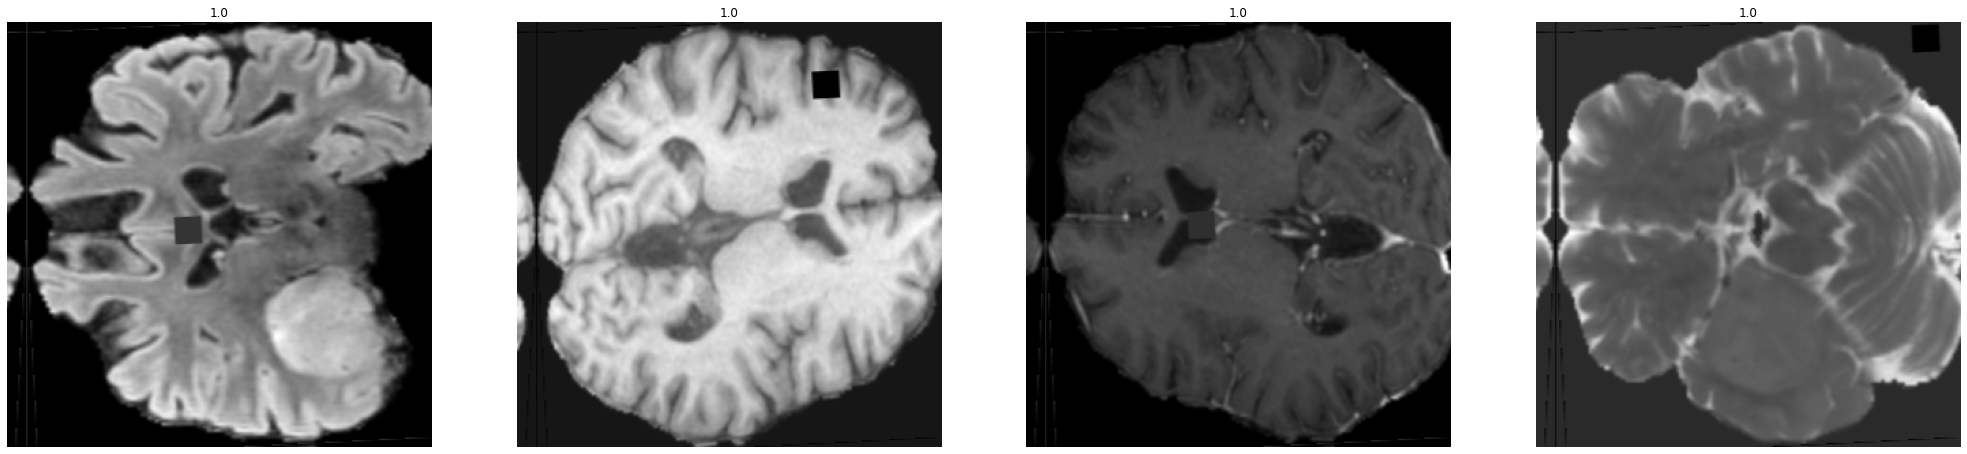

In [35]:
# wrapping sequence generator to tf.data API 
train_data = tf.data.Dataset.from_generator(
    lambda: map(tuple, train_gen),
    (tf.float32, tf.float32),
    (
        tf.TensorShape([input_height, input_width, input_depth]),
        tf.TensorShape([]),
    ),
)

# generate train sets 
train_generator = get_data_generator(train_data, 
                                     is_train=True, repeat=False, 
                                     shuffle=True, modeling_in='2D', 
                                     augment=True, batch_size=batch_size)


# visualization 
x, y = next(iter(train_generator))
print(x.shape, y.shape)  
plt.figure(figsize=(35, 15))
for i in range(input_depth):
    plt.subplot(1, input_depth, i + 1)
    plt.imshow(x[1 ,:, :, i], cmap="gray")
    plt.axis("off")
    plt.title(y[1].numpy())

## Validation Set (2D)

(3, 312, 312, 4) (3,)


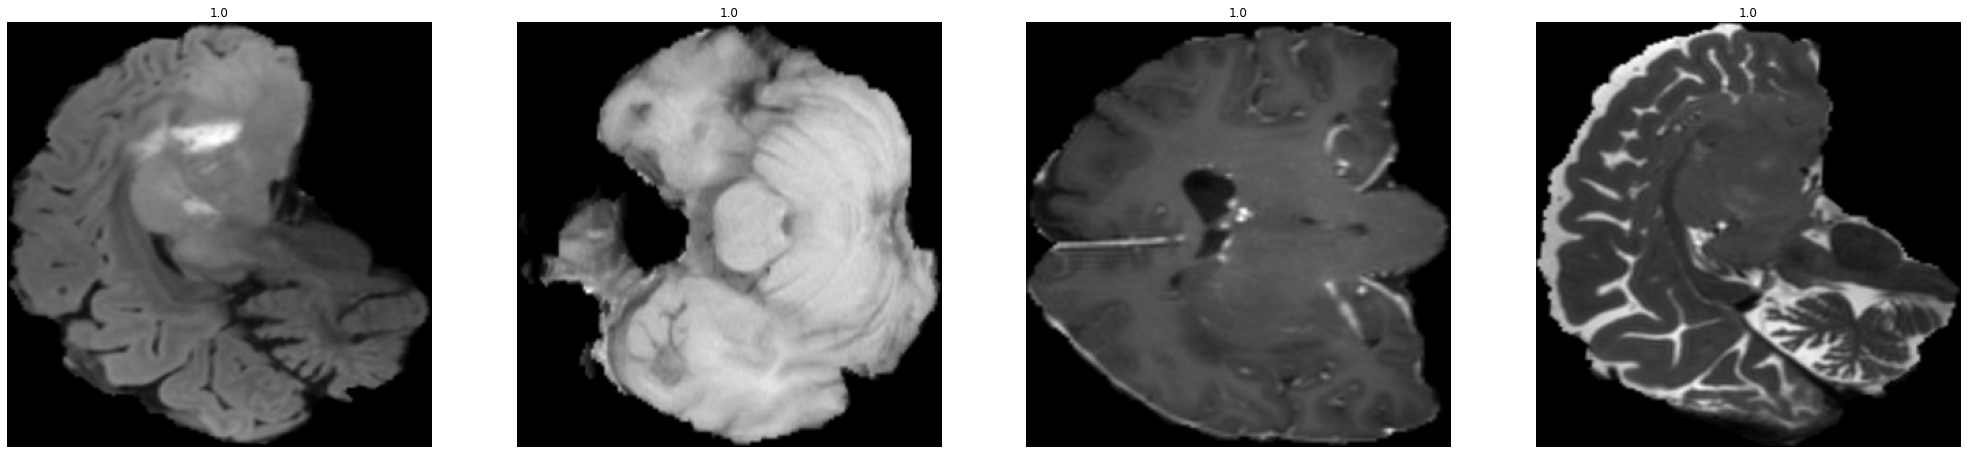

In [36]:
# wrapping sequence generator to tf.data API 
val_data = tf.data.Dataset.from_generator(
    lambda: map(tuple, val_gen),
    (tf.float32, tf.float32),
    (
        tf.TensorShape([input_height, input_width, input_depth]),
        tf.TensorShape([]),
    ),
)

# generate validation sets 
valid_generator = get_data_generator(val_data, is_train=True, 
                                     shuffle=False, repeat=False,
                                     modeling_in='2D', augment=False, 
                                     batch_size=batch_size)

# visualization 
x, y = next(iter(valid_generator))
print(x.shape, y.shape)  
plt.figure(figsize=(35, 15))
for i in range(input_depth):
    plt.subplot(1, input_depth, i + 1)
    plt.imshow(x[0 ,:, :, i], cmap="gray")
    plt.axis("off")
    plt.title(y[0].numpy())

# A. Modeling: 2D (Pre-trained Weights)

In [51]:
pre_wg = '../keras-pretrained-imagenet-weights/densenet121_imagenet_1000_no_top.h5'

input_dim = (input_height, input_width, input_depth)
input_tensor = Input(input_dim, name='input2d')
efnet = DenseNet121(weights=pre_wg, 
                       include_top = False, 
                       input_shape=(input_height, input_width, 3))
mapping3feat = Conv2D(3, (3, 3), padding='same', use_bias=False)(input_tensor)

output = efnet(mapping3feat)
output = GlobalAveragePooling2D()(output)
output = Dense(1, activation='sigmoid')(output)

tf.keras.backend.clear_session()
model = Model(input_tensor, output)
model.summary()

ValueError: The `weights` argument should be either `None` (random initialization), `imagenet` (pre-training on ImageNet), or the path to the weights file to be loaded.

In [57]:


# compiling 
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.AUC(), 
             tf.keras.metrics.BinaryAccuracy(name='bacc')],
)

# define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model.h5", monitor='val_auc', 
    mode='max', save_best_only=True
)


# fitting the model 
epochs = 5
model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=valid_generator, 
    callbacks=[checkpoint_cb], verbose=2
)

Epoch 1/5


KeyboardInterrupt: 

---

## Train Set (3D)

In [31]:
for i, j in train_gen:
    print(i.shape)
    break

(128, 128, 12)


In [32]:
# wrapping sequence generator to tf.data API 
if expand_dims:
    train_input_shape = [input_height, input_width, num_slice, input_depth] #unused
else:
    train_input_shape = [input_height, input_width, num_slice]

train_data = tf.data.Dataset.from_generator(
    lambda: map(tuple, train_gen),
    (tf.float32, tf.float32),
    (
        tf.TensorShape(train_input_shape),
        tf.TensorShape([]),
    ),
)

# generate train sets 
train_generator = get_data_generator(train_data, 
                                     is_train=True, repeat=False, 
                                     shuffle=True, modeling_in='3D', 
                                     augment=True, batch_size=batch_size)




(128, 128, 12)
(128, 128, 12)


0
(3, 128, 128, 12, 1) (3,)


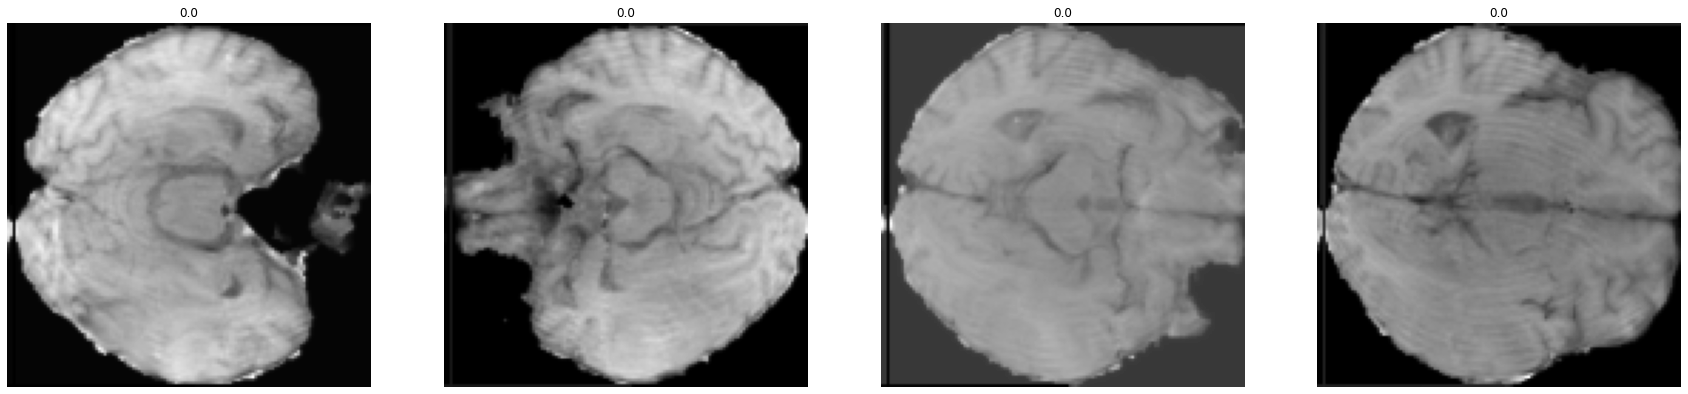

1
(3, 128, 128, 12, 1) (3,)


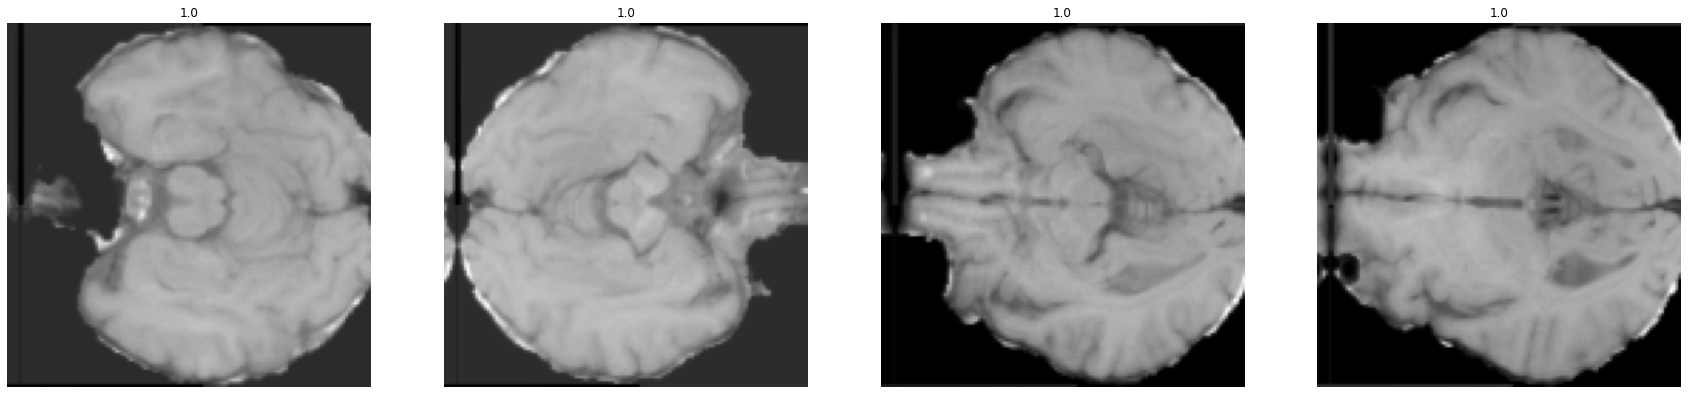

2
(3, 128, 128, 12, 1) (3,)


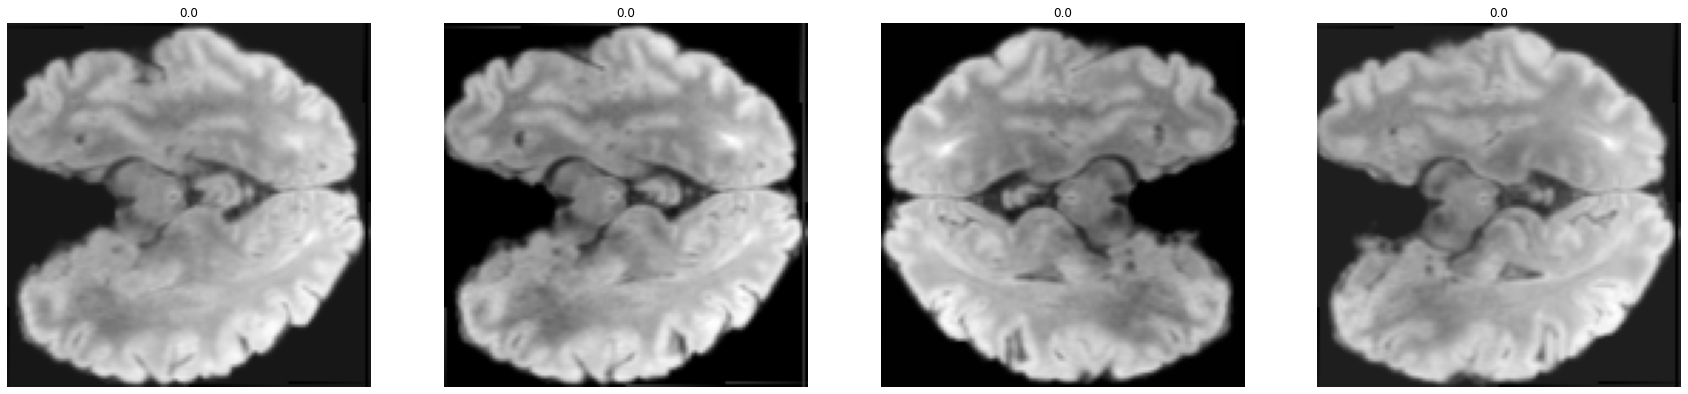

In [33]:
# visualization 
for j, (x, y) in enumerate(train_generator):
    print(j)
    print(x.shape, y.shape)
    plt.figure(figsize=(30, 7))
    for i in range(input_depth):
        plt.subplot(1, input_depth, i + 1)
        plt.imshow(x[0 ,:, :, i], cmap="gray")
        plt.title(y[0].numpy())
        plt.axis("off")
    plt.show()
    if j == 2: break

## Validation Set (3D)

(128, 128, 12)
(128, 128, 12)
(3, 128, 128, 12, 1) (3,)


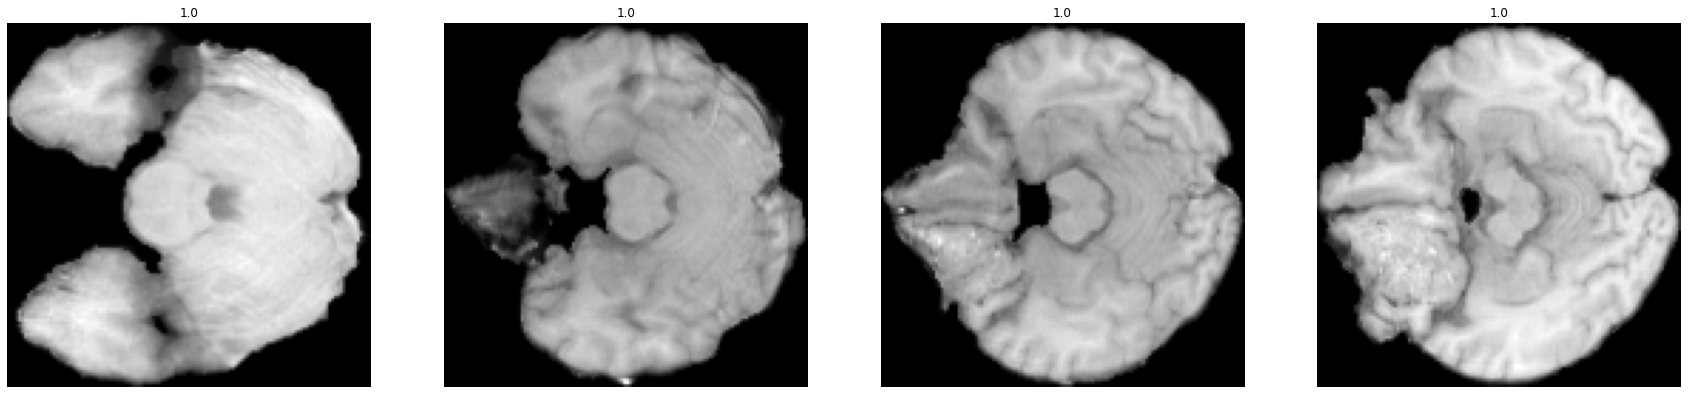

(3, 128, 128, 12, 1) (3,)


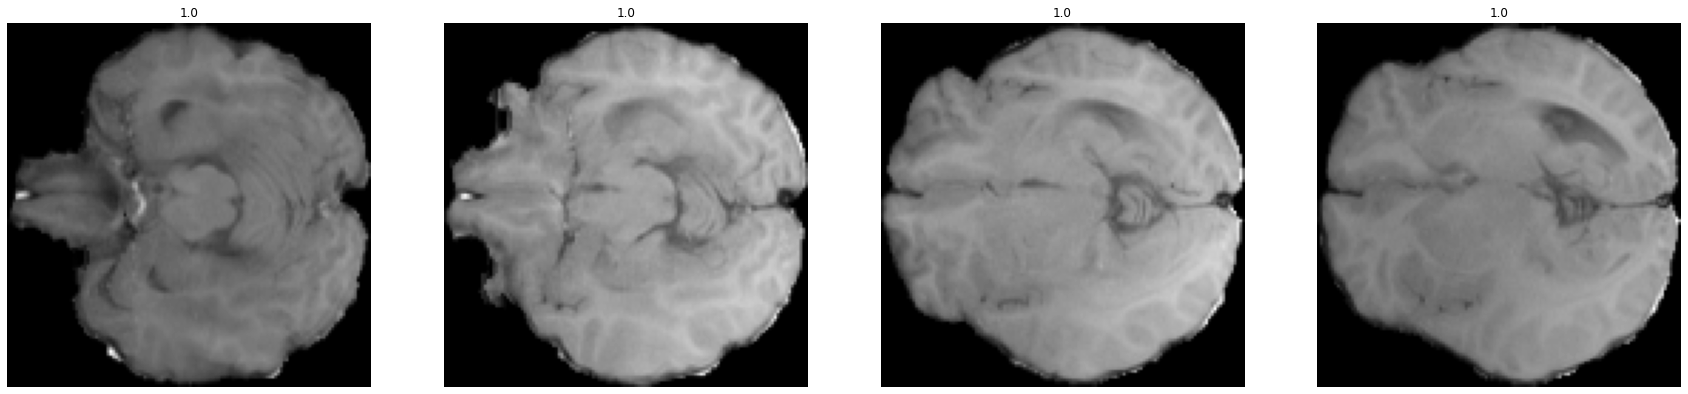

(3, 128, 128, 12, 1) (3,)


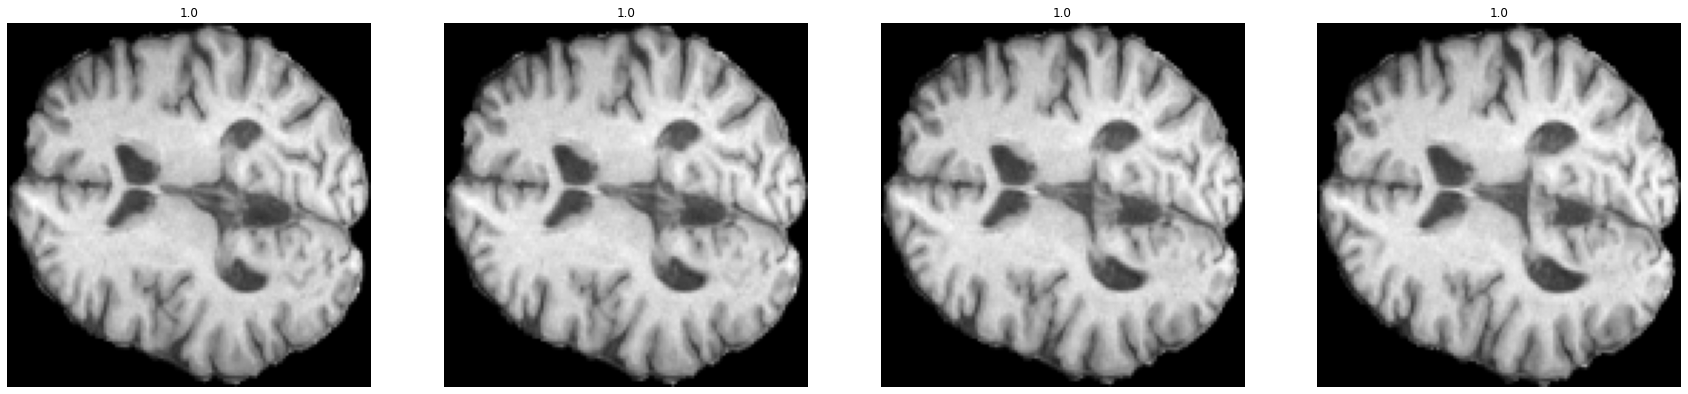

In [34]:
# wrapping sequence generator to tf.data API 
if expand_dims:
    train_input_shape = [input_height, input_width, num_slice, input_depth] #unused
else:
    train_input_shape = [input_height, input_width, num_slice]

val_data = tf.data.Dataset.from_generator(
    lambda: map(tuple, train_gen),
    (tf.float32, tf.float32),
    (
        tf.TensorShape(train_input_shape),
        tf.TensorShape([]),
    ),
)

# generate validation sets 
valid_generator = get_data_generator(val_data, is_train=True, 
                                     shuffle=False, repeat=False,
                                     modeling_in='3D', augment=False, 
                                     batch_size=batch_size)


# visualization 
for j, (x, y) in enumerate(valid_generator):
    print(x.shape, y.shape)
    plt.figure(figsize=(30, 7))
    for i in range(input_depth):
        plt.subplot(1, input_depth, i + 1)
        plt.imshow(x[0 ,:, :, i], cmap="gray")
        plt.title(y[0].numpy())
        plt.axis("off")
    plt.show()
    if j == 2: break

# B. Modeling (InceptionResNet-3D) : No Pre-trained Weights

We couldn't find any well recognized 3D pretrained weights yet, so here we will build a shallow 3D network. 

---

**Version 8 Update**: We won't train `InceptionResNet3D` now, as we have pre-trained 3D models to work with.

In [52]:


class Conv3DBatchNorm(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size, padding, strides):
        super(Conv3DBatchNorm, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # parameters 
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size 
        self.padding = padding 
        self.strides = strides 

        # layers
        self.conv = tf.keras.layers.Conv3D(self.nb_filters, self.kernel_size, 
                                           self.strides, self.padding)
        self.bn   = tf.keras.layers.BatchNormalization()
        
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        return tf.nn.relu(x)
    
    def get_config(self):
        return {
            'nb_filters': self.nb_filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'strides': self.strides
        }

In [ ]:
class Inception3DModule(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size1x1, kernel_size3x3):
        super(Inception3DModule, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # params 
        self.nb_filters = nb_filters
        self.kernel_size1x1 = kernel_size1x1
        self.kernel_size3x3 = kernel_size3x3

        # layers 
        self.conv1 = Conv3DBatchNorm(self.nb_filters, kernel_size=self.kernel_size1x1,
                                     strides=1, padding='same')
        self.conv2 = Conv3DBatchNorm(self.nb_filters, kernel_size=self.kernel_size3x3, 
                                     strides=1, padding='same')
        self.cat   = tf.keras.layers.Concatenate()

    def call(self, input_tensor, training=False):
        x_1x1 = self.conv1(input_tensor)
        x_3x3 = self.conv2(input_tensor)
        x = self.cat([x_1x1, x_3x3])
        return tf.nn.relu(x) 

    def get_config(self):
        return {
            'nb_filters': self.nb_filters,
            'kernel_size1x1': self.kernel_size1x1,
            'kernel_size3x3': self.kernel_size3x3
        }

In [ ]:
class Identity3DBlock(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size, padding, strides, shortcut = False):
        super(Identity3DBlock, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # params 
        self.shortcut = shortcut 
        self.nb_filters = nb_filters 
        self.kernel_size = kernel_size 
        self.padding = padding 
        self.strides = strides 
        
        # layers 
        self.conv1 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.conv2 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.conv3 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.inception = Inception3DModule(self.nb_filters, 
                                           kernel_size1x1 = (1,1,1),
                                           kernel_size3x3 = (3,3,3))
    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.shortcut:
            srtct = self.inception(input_tensor)
            srtct = self.conv3(srtct)
            x = Dropout(0.3)(x)
            x = Add()([x, srtct])
            return tf.nn.relu(x)
        else:
            x = Add()([x, input_tensor])
            return tf.nn.relu(x)
        
    def get_config(self):
        return {
            'shortcut': self.shortcut,
            'nb_filters': self.nb_filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'strides': self.strides,
        }

In [ ]:
def InceptionResNet3D(width=128, height=128, depth=32, num_cls=1):
    inpt = Input((width, height, depth, 1), name='input3D')
    x = ZeroPadding3D((1, 1, 1))(inpt)

    # conv3d + relu + maxplo3d 
    x = Conv3DBatchNorm(nb_filters=16, kernel_size=(3, 3, 3), 
                        strides=1, padding='valid')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=1)(x)

    # inception_resnet_block_ab
    x = Identity3DBlock(nb_filters=32, kernel_size=(3, 3, 3), 
                        padding='same', strides=1, shortcut=True)(x)
    x = Identity3DBlock(nb_filters=32, kernel_size=(3, 3, 3), 
                        padding='same', strides=1)(x)

    x = AveragePooling3D(pool_size=(2, 2, 2))(x)
    x = GlobalAveragePooling3D()(tf.nn.relu(x))
    x = Dense(num_cls, activation='sigmoid')(x)

    model = Model(inputs=inpt, outputs=x)
    return model

In [ ]:
tf.keras.backend.clear_session()
model = InceptionResNet3D(width=input_width, height=input_height, 
                          depth=input_depth, num_cls=1)
print(model.summary())

# C. 3D Model : Pre-trained Weights

The pre-trained weights of `3D` model is taken from [ZFTurbo/efficientnet_3D](https://github.com/ZFTurbo/efficientnet_3D) and [ZFTurbo/classification_models_3D](https://github.com/ZFTurbo/classification_models_3D). The weight files are uploaded and can be found from here ([efnet-3d](https://www.kaggle.com/ipythonx/keras-3d-efficientnet-imagenet-weights-b0b7)) and here ([classification-3d](https://www.kaggle.com/ipythonx/pretrained-3d-model-weights-keras)) respectively. It contains 

```
EfficientNet B0 - B7 
ResNet [18, 34, 50, 101, 152]
ResNeXt [50, 101]
SE-ResNet [18, 34, 50, 101, 152]
SE-ResNeXt [50, 101]
SE-Net [154]
DenseNet [121, 169, 201]
MobileNet
MobileNet v2
````

In [48]:
#!pip install /kaggle/input/kerasapplications -q
!pip install C:/Users/Jia Jun/Desktop/DS/Kaggle/archive (1)/model/classification_model3d_keras/classification_models_3D-1.0.2-py3-none-any.whl
!pip install C:/Users/Jia Jun/Desktop/DS/Kaggle/archive (1)/model/efficientnet3d_keras/efficientnet_3D-1.0.1-py3-none-any.whl

Processing c:\model\classification_model3d_keras\classification_models_3d-1.0.2-py3-none-any.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\model\\classification_model3d_keras\\classification_models_3D-1.0.2-py3-none-any.whl'

ERROR: Invalid requirement: 'C:/Users/Jia'


## Subclassing: BrainTumorModel3D

In [18]:
class BrainTumorModel3D(tf.keras.Model):
    def __init__(self, model):
        super(BrainTumorModel3D, self).__init__()
        self.model = model
    
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.compiled_loss(labels, predictions)
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, labels = data
        predictions = self.model(images, training=False)
        loss = self.compiled_loss(labels, predictions, 
                                  regularization_losses=[self.reg_l2_loss()])
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, *args, **kwargs):
        return self.model(inputs)
    
    def reg_l2_loss(self, weight_decay = 1e-5):
        return weight_decay * tf.add_n([
            tf.nn.l2_loss(v)
            for v in self.model.trainable_variables
        ])
    
    def build_graph(self):
        x = Input(shape=((input_height, input_width, input_depth,1)))
        return Model(inputs=[x], outputs=self.call(x))

https://keras.io/guides/transfer_learning/

In [36]:
pre_wg = 'C:/Users/Jia Jun/Desktop/DS/Kaggle/archive (1)/model/efficientnet3d_keras/efficientnet-b0_inp_channel_3_tch_0_top_False.h5'

# build models 
input_tensor = Input((input_height, input_width, 
                      num_slice, 1), name='input3D')
mapping3feat = Conv3D(3, (3,3,3), strides=(1, 1, 1), 
                                      padding='same', 
                                      use_bias=False)(input_tensor)

efnet = efn.EfficientNetB0(input_shape=(input_height, 
                                        input_width, 
                                        num_slice, 3), 
                           weights=pre_wg)
efnet.trainable = False

output = efnet(mapping3feat)
output = GlobalAveragePooling3D()(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(input_tensor, output)
print(model.summary())
# plot_model(model, show_shapes=True, expand_nested=False)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input3D (InputLayer)         [(None, 128, 128, 12, 1)] 0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 128, 128, 12, 3)   81        
_________________________________________________________________
efficientnet-b0 (Functional) (None, 4, 4, 1, 1280)     4732124   
_________________________________________________________________
global_average_pooling3d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 4,733,486
Trainable params: 1,362
Non-trainable params: 4,732,124
_________________________________________________________________
None


In [55]:
optimizer = Adam(learning_rate=1e-3)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [56]:
@tf.function
def train_step(image_batch, image_batch_labels):

    with tf.GradientTape() as tape:
        image_batch_predictions = model(image_batch)
        print('exited model')
        loss = bce(image_batch_predictions, image_batch_labels)
        print('entering backprop')

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [59]:
# custom training loop to see what is going on
for epoch in range(epochs):
    start = time.time()
    print(f'Current Epoch: {epoch}')
    for batch_number, (image_batch, image_batch_labels) in enumerate(train_generator):
        print(f'Shape of input batch: {image_batch.shape}')
        loss = train_step(image_batch, image_batch_labels)
        print(f'Current Batch Number: {batch_number} Loss: {loss}')
        print('Time for 1 batch is {} sec'.format(time.time()-start))
        
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Current Epoch: 0
Shape of input batch: (3, 128, 128, 4, 1)


<ipython-input-48-7eb619632a91>:75: RuntimeWarning: invalid value encountered in true_divide
  data = data / np.max(data)


exited model


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [38]:
# compiling 
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.AUC(), 
             tf.keras.metrics.BinaryAccuracy(name='bacc')],
)

# Define callbacks.
# todo: experiment and add more 
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model.h5", monitor='val_auc', 
    mode='max', save_best_only=True
)


# Train the model
epochs = 15
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[checkpoint_cb], verbose=2
)

Epoch 1/15


<ipython-input-27-7e50023b3180>:117: RuntimeWarning: invalid value encountered in true_divide
  data = data / np.max(data)


155/155 - 376s - loss: 0.7170 - auc_2: 0.5067 - bacc: 0.5054 - val_loss: 0.6916 - val_auc_2: 0.5083 - val_bacc: 0.5247
Epoch 2/15
155/155 - 210s - loss: 0.7154 - auc_2: 0.5043 - bacc: 0.5247 - val_loss: 0.6982 - val_auc_2: 0.5403 - val_bacc: 0.5247
Epoch 3/15
155/155 - 209s - loss: 0.7011 - auc_2: 0.5419 - bacc: 0.5204 - val_loss: 0.6936 - val_auc_2: 0.5476 - val_bacc: 0.5247
Epoch 4/15
155/155 - 207s - loss: 0.7038 - auc_2: 0.5175 - bacc: 0.5140 - val_loss: 0.6912 - val_auc_2: 0.5819 - val_bacc: 0.5247
Epoch 5/15
155/155 - 207s - loss: 0.6973 - auc_2: 0.5205 - bacc: 0.5312 - val_loss: 0.7044 - val_auc_2: 0.5772 - val_bacc: 0.5247
Epoch 6/15
155/155 - 290s - loss: 0.7082 - auc_2: 0.5000 - bacc: 0.5097 - val_loss: 0.6994 - val_auc_2: 0.5830 - val_bacc: 0.4753
Epoch 7/15
155/155 - 249s - loss: 0.7098 - auc_2: 0.5032 - bacc: 0.5204 - val_loss: 0.6933 - val_auc_2: 0.5833 - val_bacc: 0.5247
Epoch 8/15
155/155 - 249s - loss: 0.7014 - auc_2: 0.5313 - bacc: 0.5204 - val_loss: 0.7121 - val_auc_

In [39]:
model.save('weird.h5')

In [60]:
# subclassing the model in order to tweak the gradient if needed (todo)
model3D = BrainTumorModel3D(model)

# compiling 
model3D.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.AUC(), 
             tf.keras.metrics.BinaryAccuracy(name='bacc')],
)

# Define callbacks.
# todo: experiment and add more 
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model.h5", monitor='val_auc', 
    mode='max', save_best_only=True
)


# Train the model
epochs = 5
model3D.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[checkpoint_cb], verbose=2
)

NameError: name 'BrainTumorModel3D' is not defined

In [36]:
model = keras.models.load_model('weird.h5')

ValueError: Unknown layer: DepthwiseConv3D

# Using pretrained MedicalNet

MedicalNet: https://github.com/Tencent/MedicalNet

Pretrained weights from MedicalNet is in PyTorch format: https://drive.google.com/file/d/13tnSvXY7oDIEloNFiGTsjUIYfS3g3BfG/view
<br>Transfer from PyTorch to Tensorflow: https://analyticsindiamag.com/converting-a-model-from-pytorch-to-tensorflow-guide-to-onnx/

Load the saved model. Generate and pass random input so the Pytorch exporter can trace the model and save it to an ONNX file.

In [34]:
import sys
sys.path.append("C:/Users/Jia Jun/onnx-tensorflow")
import torch
from torch.autograd import Variable
import onnx
from onnx_tf.backend import prepare

C:/Users/Jia Jun/onnx-tensorflow\onnx_tf\backend.py:282: SyntaxWarning: "is" with a literal. Did you mean "=="?
  name = get_unique_suffix() + name if name[0] is "_" else name


In [ ]:
def torch_to_tf(model_class, weights_path):
    trained_model = resnet10()
    trained_model.load_state_dict(torch.load(weights_path))
    dummy_input = Variable(torch.randn(1, 1, 28, 28))
    torch.onnx.export(trained_model, dummy_input, "mnist.onnx")
    

In [ ]:
torch_to_tf(model_class, weights_path)

In [1]:
import torch

Ref: https://github.com/Tencent/MedicalNet/blob/master/models/resnet.py

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

__all__ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]


def conv3x3x3(in_planes, out_planes, stride=1, dilation=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        dilation=dilation,
        stride=stride,
        padding=dilation,
        bias=False)


def downsample_basic_block(x, planes, stride, no_cuda=False):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if not no_cuda:
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes, dilation=dilation)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_input_D,
                 sample_input_H,
                 sample_input_W,
                 num_seg_classes,
                 shortcut_type='B',
                 no_cuda = False):
        self.inplanes = 64
        self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            1,
            64,
            kernel_size=7,
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            bias=False)
            
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=1, dilation=4)

        self.conv_seg = nn.Sequential(
                                        nn.ConvTranspose3d(
                                        512 * block.expansion,
                                        32,
                                        2,
                                        stride=2
                                        ),
                                        nn.BatchNorm3d(32),
                                        nn.ReLU(inplace=True),
                                        nn.Conv3d(
                                        32,
                                        32,
                                        kernel_size=3,
                                        stride=(1, 1, 1),
                                        padding=(1, 1, 1),
                                        bias=False), 
                                        nn.BatchNorm3d(32),
                                        nn.ReLU(inplace=True),
                                        nn.Conv3d(
                                        32,
                                        num_seg_classes,
                                        kernel_size=1,
                                        stride=(1, 1, 1),
                                        bias=False) 
                                        )

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride,
                    no_cuda=self.no_cuda)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv_seg(x)

        return x

    
def resnet10(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model

def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-152 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-200 model.
    """
    model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [36]:
weights_path = 'C:\\Users\\Jia Jun\\Desktop\\DS\\Kaggle\\archive (1)\\pretrained\\MedicalNet_pytorch_files2\\pretrain\\resnet_10.pth'

input_D = 14 # Default: 56
input_H = 28 # Default: 448
input_W = 28 # Default: 448
num_seg_classes = 2

trained_model = resnet10(sample_input_D = input_D, 
                         sample_input_H = input_H, 
                         sample_input_W = input_W, 
                         num_seg_classes = num_seg_classes,
                         shortcut_type = 'B',
                         no_cuda = False)

pretrain = torch.load(weights_path)
net_dict = trained_model.state_dict() # sometimes the keys are absent in the model.
pretrain_dict = {k[7:]: v for k, v in pretrain['state_dict'].items() if k[7:] in net_dict.keys()} # remove 'module.' from keys' name
net_dict.update(pretrain_dict)
# if you want to save missing parameters: https://github.com/Tencent/MedicalNet/blob/master/model.py

trained_model.load_state_dict(net_dict)
# trained_model.eval()
dummy_input = Variable(torch.randn(64, 1, 7, 7, 7))
torch.onnx.export(trained_model, dummy_input, "model.onnx")

<ipython-input-18-ee158a5af618>:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


Load the ONNX file and import it to Tensorflow

In [40]:
model = onnx.load('model.onnx')
tf_rep = prepare(model)
tf_rep.export_graph('./models/model_simple')

INFO:tensorflow:Assets written to: ./models/model_simple.pb\assets


In [42]:
imported = tf.saved_model.load('./models/model_simple')

In [49]:
l = tf.keras.models.load_model('./models/model_simple')

In [60]:
def load_pb(path_to_pb):
    with tf.io.gfile.GFile(path_to_pb, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph
    
tf_graph = load_pb('./models/model_simple/saved_model.pb')
sess = tf.Session(graph=tf_graph)

# Show tensor names in graph
for op in tf_graph.get_operations():
    print(op.values())

output_tensor = tf_graph.get_tensor_by_name('test_output:0')
input_tensor = tf_graph.get_tensor_by_name('test_input:0')

output = sess.run(output_tensor, feed_dict={input_tensor: dummy_input})
print(output)

DecodeError: Wrong wire type in tag.

medicalnet
medicalzoo

```
- [WIP]: Training : ✔
- [WIP]: Inference
```

# Additional ideas: Preprocessing

1. Ref: https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train

# Additional ideas: Models

1. Ref: https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train

Width = Height = 256, 64 slices in from the middle from each 4 modalities. Hence the shape can be either: (256, 256, 256) or (4, 256, 256, 64).